# The Speed of New Pandas 2.0 Against Polars and Data.table - Still Not Good Enough
![](images/img.png)

### Introduction

People have been complaining about Pandas' speed ever since they tried reading their first gigabyte-sized dataset with `read_csv` and realized they had to wait for - _gasp_ - five seconds. And yes, I was one of those whiners. 

Five seconds might not sound a lot, but when loading the dataset itself takes that much runtime, it usually means subsequent operations will take as long. And since speed is one of the most important things in quick, dirty data exploration, you can get _very_ frustrated. 

For this reason, folks at PyData recently announced the planned release of Pandas 2.0 with the freshly minted PyArrow backend. For those totally unaware, PyArrow on its own, is a nifty little library designed for high performance, memory-efficient manipulation of arrays. 

People are sincerely hoping the new backend will bring considerable speed-ups over the vanilla Pandas. In this article, we will test that glimmer of hope by comparing the PyArrow backend against two of the fastest Data.frame libraries: Data.table and Polars.

### Haven't people already done this?

What is the point of doing this benchmark when H20 currently runs the popular [__Database-like Ops Benchmark__](https://h2oai.github.io/db-benchmark/) that measures the computation speed of almost 15 libraries on three data manipulation operations over three different dataset sizes? My benchmark couldn't possibly be as complete.

Well, for one, the benchmark doesn't include Pandas with the PyArrow backend and was last updated in 2021, which was ages ago. 

Secondly, the benchmark was run on a monster of a machine with 40 CPU cores hopped-up on 128 GB RAM and 20 GB GPU to boot ([cuDF](https://github.com/rapidsai/cudf), anyone?). The general populace doesn't usually have access to such machines, so it is important to see the differences between DataFrame libraries on everyday machines like mine. It features a modest CPU with a dozen cores and 32 gigs of RAM.

Lastly, I advocate for total transparency in the process, so I will explain the code of the benchmark in detail and present it as a Gist to run it on your own machine.

What is the point? 

- Well, first and foremost, we get to take the new pyarrow backed for a quick spin before it is released to the public which is very soon
- Second, the popular H2O benchmark of dataframe libraries gives me headache if I read too long
- Besides that benchmark was run on a monster of a machine with 128 GB RAM and 40 CPU cores. 
- To really see the differences between these libraries that would actually apply to the general populace, we should try it on a vanilla machine like mine which features 12-core cpu paired with 32 gigs of RAM.
- Also, I advocate for total transparency in the process so you will see exactly how I run the benchmark code. Should be fun, eh?

### Installation and setup

We start by installing the RC (release candidate) of Pandas 2.0 along with the latest versions of PyArrow, Data.table and Polars.

```python
pip install -U "pandas==2.0.0rc0" pyarrow datatable polars
```

In [1]:
import datatable as dt
import pandas as pd
import polars as pl

In [2]:
dt.__version__

'1.0.0'

In [3]:
pd.__version__

'2.0.0rc0'

In [4]:
pl.__version__

'0.16.14'

Let's also set up the paths to the dataset in two formats - CSV and Parquet.

The data is synthetically generated with NumPy and Faker libraries to simulate typical features in a census dataset. 

In [49]:
from pathlib import Path

data = Path("data")
data_csv = data / "census_data.csv"
data_parquet = data / "census_data.parquet"

> If you are interested in the details of the dataset, you can check out [this GitHub gist](https://gist.github.com/BexTuychiev/92a1fbbed96fa52cec47fe2cd725cf3e).

There are 50 million rows of seven features, clocking up the file size to about 2.5 GBs. 

### Benchmark results

- Let's see the results before the code because you are here for that anyway. 
- Across all categories, the new Pandas backed comes in last. 
- The parquet file operations aren't supported in Data.table so please don't mistake the nonexistent bars to 0 runtime. 

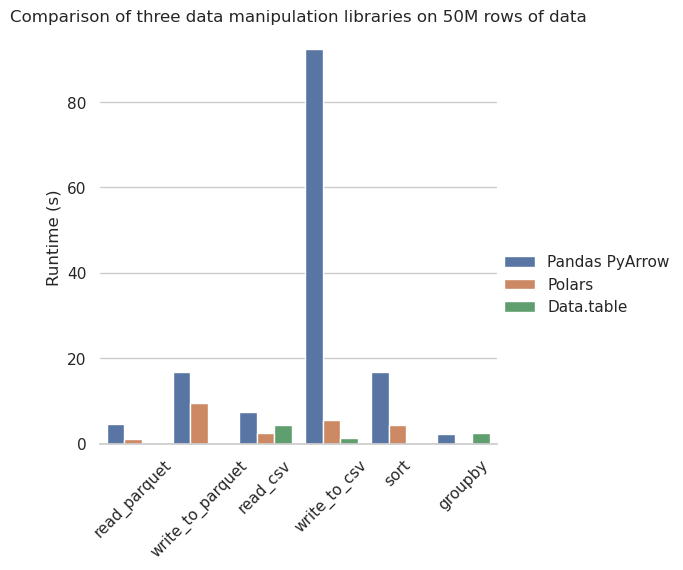

### Benchmark code

In [6]:
import time

import datatable as dt
import pandas as pd
import polars as pl

# Define a DataFrame to store the results
results_df = pd.DataFrame(
    columns=["function", "library", "runtime"]
)


# Define the timer decorator
def timer(results):
    def decorator(func):
        def wrapper(*args, **kwargs):
            start_time = time.time()
            result = func(*args, **kwargs)
            end_time = time.time()
            elapsed_time = end_time - start_time
            results.loc[len(results)] = [
                func.__name__,
                kwargs["library"],
                elapsed_time,
            ]
            return result

        return wrapper

    return decorator


# Task 1: Reading CSVs
@timer(results_df)
def read_csv(path, library):
    if library == "pandas":
        return pd.read_csv(path, engine="pyarrow")
    elif library == "polars":
        return pl.read_csv(path)
    elif library == "datatable":
        return dt.fread(str(path))


# Task 2: Writing to CSVs
@timer(results_df)
def write_to_csv(df, path, library):
    if library == "pandas":
        df.to_csv(path, index=False)
    elif library == "polars":
        df.write_csv(path)
    elif library == "datatable":
        dt.Frame(df).to_csv(str(path))


# Task 3: Reading to Parquet
@timer(results_df)
def read_parquet(path, library):
    if library == "pandas":
        return pd.read_parquet(path, engine="pyarrow")
    elif library == "polars":
        return pl.read_parquet(path)
    elif library == "datatable":
        return None


# Task 4: Writing to Parquet
@timer(results_df)
def write_to_parquet(df, path, library):
    if library == "pandas":
        df.to_parquet(path, index=False)
    elif library == "polars":
        df.write_parquet(str(path))
    elif library == "datatable":
        # Not implemented
        return None

In [7]:
# Task 5: Sort
@timer(results_df)
def sort(df, column, library):
    if library == "pandas":
        return df.sort_values(column)
    elif library == "polars":
        return df.sort(column)
    elif library == "datatable":
        return df.sort(column)


# Task 6: Groupby
@timer(results_df)
def groupby(df, library):
    if library == "pandas":
        return df.groupby("education")["age"].mean()
    elif library == "polars":
        return df.groupby("education").agg(pl.mean("age"))
    elif library == "datatable":
        return df[:, dt.mean(dt.f.age), dt.by("education")]

```python
data = Path("data")
data_csv = data / "census_data.csv"
data_parquet = data / "census_data.parquet"

pd.read_parquet(data_parquet).sample(100000).to_parquet(
    "data/small.parquet"
)
pd.read_csv(data_csv).sample(100000).to_csv(
    "data/small.csv", index=False
)
```

In [13]:
from pathlib import Path

# Define the file paths
data = Path("data")
data_csv = data / "census_data.csv"
data_parquet = data / "census_data.parquet"


# libraries = ["pandas", "polars", "datatable"]
l = "datatable"

# Task 3/4
df = read_parquet(data_parquet, library=l)
write_to_parquet(df, data_parquet, library=l)

# Task 1/2
df = read_csv(data_csv, library=l)
write_to_csv(df, data_csv, library=l)

# Task 5/6
sort(df, "age", library=l)
groupby(df, library=l)

,education,age
,▪▪▪▪,▪▪▪▪▪▪▪▪
0,College,39.5071
1,Graduate,39.501
2,High School,39.4972


In [15]:
results_df.to_csv("data/results.csv", index=False)

In [34]:
results_df.columns = ["Function", "Library", "Runtime (s)"]

In [39]:
results_df.replace(
    {
        "pandas": "Pandas PyArrow",
        "polars": "Polars",
        "datatable": "Data.table",
    },
    inplace=True,
)

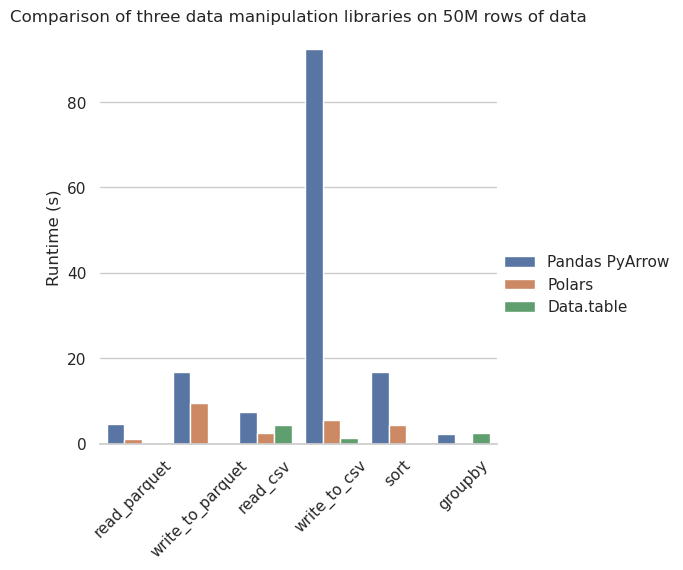

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=results_df,
    kind="bar",
    x="Function",
    y="Runtime (s)",
    hue="Library",
)

g.legend.set_title("")
g.despine(left=True)

plt.xticks(rotation=45)
plt.xlabel("")
plt.title(
    "Comparison of three data manipulation libraries on 50M rows of data"
)
plt.show()

### Should you switch?

- Time for the million-dollar question - should you switch?

### 